# Quantum phase estimation

Quantum phase estimation estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$ for a given unitary operator $U$. 

Here $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. 

Since $U$ is unitary, all of its eigenvalues must be complex numbers with a norm of 1.

Let's consider the $P$ gate, whose matrix is
$$
P(\phi) = \begin{bmatrix} 1 & 0 \\ 0 & e^{i\phi} \end{bmatrix}
$$
according to the specified parameter $\phi$. We can see that $|1\rangle = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$ is an eigenvector of this operator.

$$ P(\phi)|1\rangle = \begin{bmatrix} 1 & 0 \\ 0 & e^{i\phi} \end{bmatrix} \begin{bmatrix} 0 \\ 1 \end{bmatrix} = \begin{bmatrix} 0 \\ e^{i\phi} \end{bmatrix} = e^{i\phi} |1\rangle $$

i.e. $\theta = \frac{\phi}{2\pi}$.

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_distribution, plot_histogram, array_to_latex
from qiskit.result import Result
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import Aer
from math import sqrt, pi

### use vector_to_latex code from qiskit 0.44
from vector_to_latex import *

import numpy as np
import cmath

In [3]:
qc = QuantumCircuit(1)
phi = 5*pi/8
print('phi = {} pi = {} = {} deg'.format(phi/pi,phi,phi*180/pi))
qc.p(phi,0)
qc.draw()

phi = 0.625 pi = 1.9634954084936207 = 112.5 deg


┌─────────┐
q: ┤ P(5π/8) ├
   └─────────┘

In [4]:
usim = Aer.get_backend('unitary_simulator')
unitary = usim.run(qc).result().get_unitary()
array_to_latex(unitary,prefix='\\text{U = }\n')

<IPython.core.display.Latex object>

In [5]:
uabs=abs(np.asarray(unitary)[1][1])
uphase=cmath.phase(np.asarray(unitary)[1][1])
print('{} = {} exp(i {})'.format(np.asarray(unitary)[1][1],uabs,uphase))

(-0.3826834323650897+0.9238795325112867j) = 1.0 exp(i 1.9634954084936207)


A controlled-p gate between two qubits looks like this, and it does not matter which is which between the target and control because the operation is equivalent plus or minus some global phase.

In [6]:
qc = QuantumCircuit(2)
qc.cp(phi, 0,1)
qc.draw()

q_0: ─■────────
      │P(5π/8) 
q_1: ─■────────

In [7]:
usim = Aer.get_backend("unitary_simulator")
unitary = usim.run(qc).result().get_unitary()
array_to_latex(unitary,prefix = "\\text{U = }\n")

<IPython.core.display.Latex object>

In [8]:
qcount=3

qc = QuantumCircuit(qcount+1)
for q in range(qcount):
    qc.h(q)

qc.x(qcount)
qc.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ X ├
     └───┘

In order to perform QPE we need some counting qubits, which we put into $|+\rangle$ with $H$ gates, and a $|\phi\rangle$ qubit which we will put into state $|1\rangle$ with an $X$ since this is the eigenstate of the operator.

Then we need to perform controlled-$P(\theta)$ on the $|\phi\rangle$ qubit controlled by each of the counting qubits, $2^n$ times on qubit $q_n$.

In [9]:
for q in range(qcount):
    twon=2**q
    for i in range(twon):
        qc.cp(phi, q,qcount)
    
    
qc.draw()

┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │P(5π/8)  │P(5π/8)  │P(5π/8)  │P(5π/8)  │P(5π/8)  │P(5π/8) »
q_3: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
«               
«q_0: ──────────
«               
«q_1: ──────────
«               
«q_2: ─■────────
«      │P(5π/8) 
«q_3: ─■────────
«

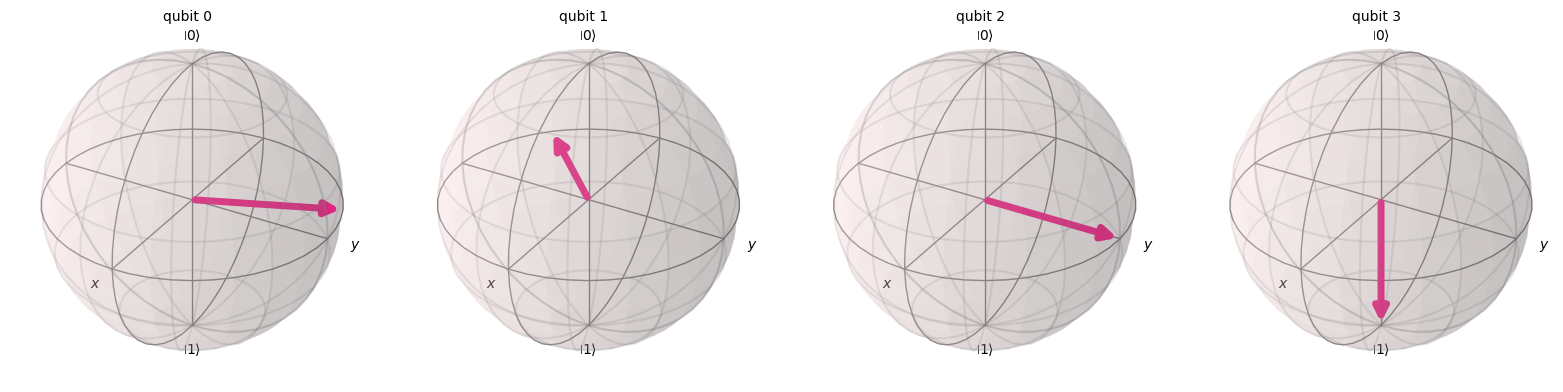

In [10]:
ssvim = Aer.get_backend("statevector_simulator")
state = ssvim.run(qc).result().get_statevector()
plot_bloch_multivector(state)

We can see that the counting qubits are in a QFT state, rotated according to the phase of the $P$ gate multiplied by a factor depending on the significance of each qubit. Of course it would be easy if we could read the state of the counting qubits directly. But to actually read them, we need to put them into the computational basis via the inverse-QFT. To make it easier to re-run, I will repeat the whole circuit from the beginning first.

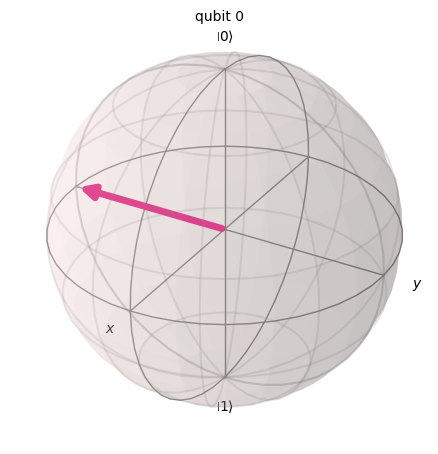

In [14]:
qc = QuantumCircuit(1)
qc.h(0)
qc.p(pi/2,0)
qc.h(0)
qc.draw()
svsim = Aer.get_backend('statevector_simulator')
state = svsim.run(qc).result().get_statevector()
display(plot_bloch_multivector(state))

In [15]:
phi=pi/4 # 5*pi/8

qcount=3 # number of counting qubits

qc = QuantumCircuit(qcount+1)
for q in range(qcount):
    qc.h(q)

qc.x(qcount)

for q in range(qcount):
    twon=2**q
    for i in range(twon):
        qc.cp(phi, q,qcount)

qc.barrier()

# inverse-QFT

# first we swap the counting qubits around to deal with qiskit's ordering

for qubit in range(int(qcount/2)):
        qc.swap(qubit, qcount-qubit-1)

# then we unwind each qubit according to its significance, and apply an H;
# the |0> or |1> which results is used to control the next qubits' unwinding
        
for j in range(0,qcount):
    for m in range(j):
        qc.cp(-np.pi/float(2**(j-m)), m, j)

    qc.h(j)
    #qc.barrier()
    #svsim = Aer.get_backend('statevector_simulator')
    #state = svsim.run(qc).result().get_statevector()
    #display(plot_bloch_multivector(state))

qc.barrier()

qc.draw()

┌───┐                                                                ░    »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────────░──X─»
     ├───┤ │                                                              ░  │ »
q_1: ┤ H ├─┼────────■────────■────────────────────────────────────────────░──┼─»
     ├───┤ │        │        │                                            ░  │ »
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■────────░──X─»
     ├───┤ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  ░    »
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■────────░────»
     └───┘                                                                ░    »
«     ┌───┐                                         ░ 
«q_0: ┤ H ├─■──────────────■────────────────────────░─
«     └───┘ │P(-π/2) ┌───┐ │                        ░ 
«q_1: ──────■────────┤ H ├─┼─────────■──────────────░─
«                    └───┘ │P(-π/4)  │P(-π/2) ┌───┐ ░ 
«q_2: ─────────────────────■─────────■────────┤ H ├─░─
«                                             └───┘ ░ 
«q_3: ──────────────────────────────────────────────░─
«                                                   ░

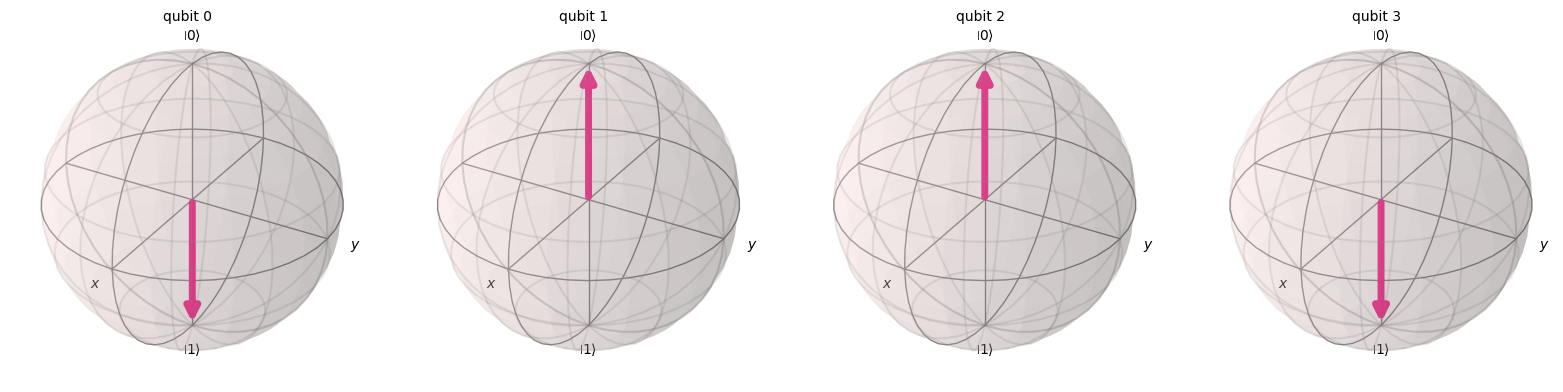

In [16]:
svsim = Aer.get_backend('statevector_simulator')
state = svsim.run(qc).result().get_statevector()
plot_bloch_multivector(state)

{np.str_('1001'): np.float64(1.0)}


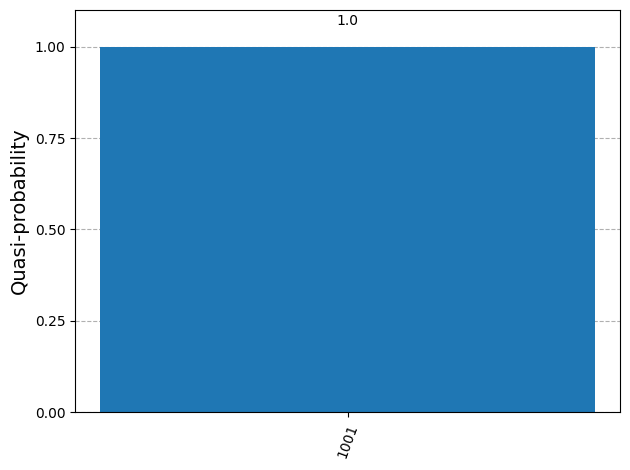

In [17]:
result = svsim.run(qc, shots=1, memory=False).result()
print(result.get_counts())
plot_histogram(result.get_counts())

In [18]:
maxweight=0.0
for measi in range(len(result.get_counts())):
    measure = (list(result.get_counts().keys())[measi])[::-1] # reverse to fit qiskit's qubit ordering
    weight = (list(result.get_counts().values())[measi])
    # print(measure, weight, prevweight)
    if weight>maxweight:
        maxweight=weight
        maxmeasure=measure

qout=[]
qval=0.0

for i in range(len(maxmeasure)-1):
    qout.append(maxmeasure[i])
    qval=qval+(2.0**float(i))*float(maxmeasure[i])
    # print('qubit {} is {}'.format(i,measure[i]))
    
qout = qout[::-1] # 
nval = 2*qval/(2**qcount)
print('psi qubit is {}'.format(maxmeasure[len(maxmeasure)-1]))
print('output qubits are {}'.format(qout))
print('output value is {}'.format(qval))
    
print('result is {} pi = pi/{}'.format(nval,1/nval))

psi qubit is 1
output qubits are ['0', '0', '1']
output value is 1.0
result is 0.25 pi = pi/4.0


However, note that this only gives a sensible single output in terms of the statevector if $\phi = \pi/(2^n)$ with $n$ larger than the number of counting qubits. The result is $$2\pi \times \frac{\textrm{output value}}{2^\textrm{counting qubits}}$$

For the case of 3 counting qubits so a maximum count of 8, and $\phi = \pi/(2^2) = \pi/4$, the output is $001 = 1$, corresponding to 1/8 of a full rotation: the result is calculated from $2\pi\times1 / 2^3 = \pi/4$.

Otherwise, we will have some sort of entanglement of the qubits such that there's a weighted superposition of the different possible outputs, and we need to interpret this result, but we should of course measure the result into classical bits.

In [20]:
phi=pi/5

qcount=8 # number of counting qubits, if this is too large the circuit won't draw but it will still work

qc = QuantumCircuit(qcount+1,qcount)
for q in range(qcount):
    qc.h(q)

qc.x(qcount)

for q in range(qcount):
    twon=2**q
    for i in range(twon):
        qc.cp(phi, q,qcount)

qc.barrier()

# inverse-QFT

# first we swap the counting qubits around to deal with qiskit's ordering

for qubit in range(int(qcount/2)):
        qc.swap(qubit, qcount-qubit-1)

# then we unwind each qubit according to its significance, and apply an H;
# the |0> or |1> which results is used to control the next qubits' unwinding
        
for j in range(0,qcount):
    for m in range(j):
        qc.cp(-np.pi/float(2**(j-m)), m, j)

    qc.h(j)


qc.barrier()

# measure

for n in range(qcount):
    qc.measure(n,n)

qc.draw()

┌───┐                                                               »
q_0: ┤ H ├─■─────────────────────────────────────────────────────────────»
     ├───┤ │                                                             »
q_1: ┤ H ├─┼────────■────────■───────────────────────────────────────────»
     ├───┤ │        │        │                                           »
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■───────»
     ├───┤ │        │        │        │        │        │        │       »
q_3: ┤ H ├─┼────────┼────────┼────────┼────────┼────────┼────────┼───────»
     ├───┤ │        │        │        │        │        │        │       »
q_4: ┤ H ├─┼────────┼────────┼────────┼────────┼────────┼────────┼───────»
     ├───┤ │        │        │        │        │        │        │       »
q_5: ┤ H ├─┼────────┼────────┼────────┼────────┼────────┼────────┼───────»
     ├───┤ │        │        │        │        │        │        │       »
q_6: ┤ H ├─┼────────┼────────┼────────┼────────┼────────┼────────┼───────»
     ├───┤ │        │        │        │        │        │        │       »
q_7: ┤ H ├─┼────────┼────────┼────────┼────────┼────────┼────────┼───────»
     ├───┤ │P(π/5)  │P(π/5)  │P(π/5)  │P(π/5)  │P(π/5)  │P(π/5)  │P(π/5) »
q_8: ┤ X ├─■────────■────────■────────■────────■────────■────────■───────»
     └───┘                                                               »
c: 8/════════════════════════════════════════════════════════════════════»
                                                                         »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_3: ─■────────■────────■────────■────────■────────■────────■────────■───────»
«      │        │        │        │        │        │        │        │       »
«q_4: ─┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼───────»
«      │        │        │        │        │        │        │        │       »
«q_5: ─┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼───────»
«      │        │        │        │        │        │        │        │       »
«q_6: ─┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼───────»
«      │        │        │        │        │        │        │        │       »
«q_7: ─┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼───────»
«      │P(π/5)  │P(π/5)  │P(π/5)  │P(π/5)  │P(π/5)  │P(π/5)  │P(π/5)  │P(π/5) »
«q_8: ─■────────■────────■────────■────────■────────■────────■────────■───────»
«                                                                             »
«c: 8/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_3: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_4: ─■────────■────────■────

{'00011001': 26, '00011010': 58, '00011011': 7, '00101010': 1, '00011000': 3, '00001010': 1, '00010111': 3, '00011100': 1}


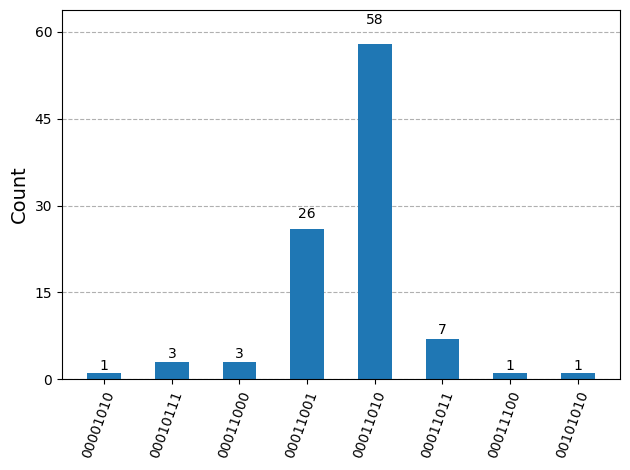

In [21]:
shots=100
result = svsim.run(qc, shots=shots, memory=False).result()
print(result.get_counts())
plot_histogram(result.get_counts())

In [22]:
counts = result.get_counts()
value=0.0
nval=0.0
for i in counts:
    vali=int(i,base=2)
    value=value+vali*counts[i]/shots

nval = 2*value/(2**qcount)
print('output value is {}'.format(value))
print('result is {} pi = pi/{}'.format(nval,1/nval))

output value is 25.680000000000003
result is 0.20062500000000003 pi = pi/4.984423676012461


Of course, in this case we need to know $\theta$ in order to be able to apply the controlled phase rotation as many times as needed. For $N$ counting qubits we apply the rotation $2^N - 1$ times. We can choose whether to improve our accuracy using more counting qubits, or running the circuit many times to improve the statistics.  